<a href="https://colab.research.google.com/github/Shrishml/Stock_analysis/blob/main/lstm_stock_price_prediction_n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install quandl

**Stock prices follows Brownian motion, making it very difficult to predict. I personally do not belive in technical trading. I am just explroing some the deep learning techniques to predict the stock price.**

In [ ]:
import keras
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

 Installing quandl



In [ ]:
def adjust_stock_split(my_data, split_dates, split_val):
    split_dates = pd.to_datetime(split_dates).sort_values()
    for i in range(len(split_dates)):
        my_data.Close[my_data.index<split_dates[i]]= my_data.Close[my_data.index<split_dates[i]]/split_val[i]
    return my_data

In [ ]:
my_data =  quandl.get('BSE/BOM500570', start_date='2000-03-13', end_date='2021-08-09')
my_data.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,
2000-03-13,136.75,136.75,119.15,120.90,125.539901,790942.0,2845.0,99294780.0,NaN,NaN,17.60,-15.85
2000-03-14,123.00,130.55,120.10,130.55,127.875925,727722.0,2322.0,93058124.0,NaN,NaN,10.45,7.55
2000-03-15,133.90,139.50,130.00,133.40,135.698842,699924.0,2947.0,94978876.0,NaN,NaN,9.50,-0.50
2000-03-16,144.00,144.00,144.00,144.00,144.000000,2300.0,1.0,331200.0,NaN,NaN,0.00,0.00
2000-03-21,147.80,153.50,143.20,149.80,148.103816,912761.0,3717.0,135183387.0,NaN,NaN,10.30,2.00


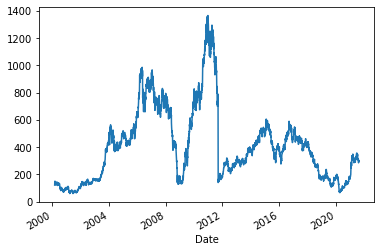

In [ ]:
my_data['Close'].plot()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

We make the last 10 days of data as the input data and data of 11th day as output data.

Here, We are just trying to predict the one day data.

Which is not very useful though.

In [ ]:
cl = my_data.Close.astype('float32')
train = cl[0:int(len(cl)*0.90)]
scl = MinMaxScaler()
#Scale the data
scl.fit(train.values.reshape(-1,1))
cl =scl.transform(cl.values.reshape(-1,1))
#Create a function to process the data into lb observations look back slices
# and create the train test dataset (90-10)

my_data['Close_scaled']=cl

def processData(data,lb):
    new_data = pd.DataFrame(index = my_data.index, data=np.array([data.Close_scaled.shift(-1*i).values for i in range(lb)]).T)
    Y=my_data['Close'].iloc[lb:].values
    X=new_data.values
    return np.array(X[:len(data)-lb-1]),np.array(Y[:len(data)-lb-1])

lb=10
X,y = processData(my_data,lb)

X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

4782 10
532 10
4782
532


In [ ]:
from keras.layers import LSTM
from keras import Sequential
from keras.layers import Dense
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

from sklearn.metrics import r2_score

We train LSTM(Long Short Term Memory) model with the data.

In [ ]:
model = Sequential()

model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=150,validation_data=(X_test,y_test),shuffle=False) #, callbacks =[earlystopping])
model.summary()

Epoch 1/150
150/150 [==============================] - 7s 36ms/step - loss: 177087.4002 - val_loss: 23112.7676
Epoch 2/150
150/150 [==============================] - 5s 34ms/step - loss: 157205.2671 - val_loss: 16494.2383
Epoch 3/150
150/150 [==============================] - 5s 34ms/step - loss: 141864.6494 - val_loss: 11808.0322
Epoch 4/150
150/150 [==============================] - 5s 33ms/step - loss: 128825.8398 - val_loss: 8836.6299
Epoch 5/150
150/150 [==============================] - 5s 34ms/step - loss: 117930.0073 - val_loss: 7318.5537
Epoch 6/150
150/150 [==============================] - 5s 33ms/step - loss: 108904.9576 - val_loss: 7026.4512
Epoch 7/150
150/150 [==============================] - 5s 33ms/step - loss: 101519.2575 - val_loss: 7754.2085
Epoch 8/150
150/150 [==============================] - 5s 33ms/step - loss: 95561.4562 - val_loss: 9331.7764
Epoch 9/150
150/150 [==============================] - 5s 33ms/step - loss: 90785.5886 - val_loss: 11590.3535
Epoch 10

Predicting next day price, Training data



Text(0.5, 1.0, 'Train Dataset (Next day prediction)')

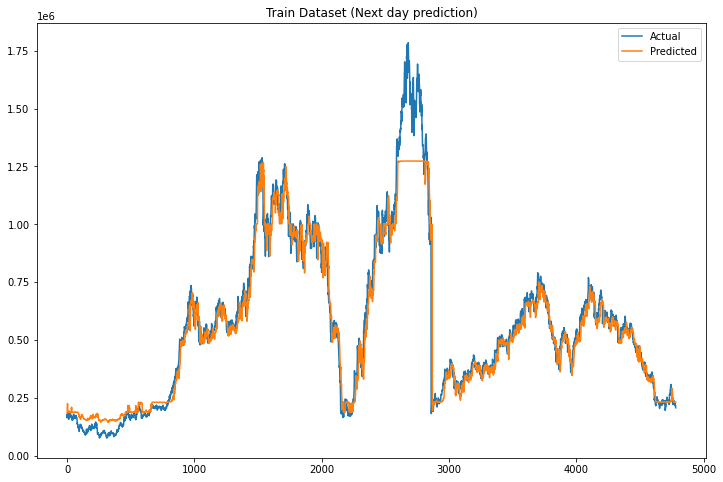

In [ ]:
plt.figure(figsize=(12,8))
y_train_pred = model.predict(X_train)
plt.plot(scl.inverse_transform(y_train.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(y_train_pred), label="Predicted")
plt.legend()
plt.title("Train Dataset (Next day prediction)")

Predicting next day price, testing data


Text(0.5, 1.0, 'Test Dataset')

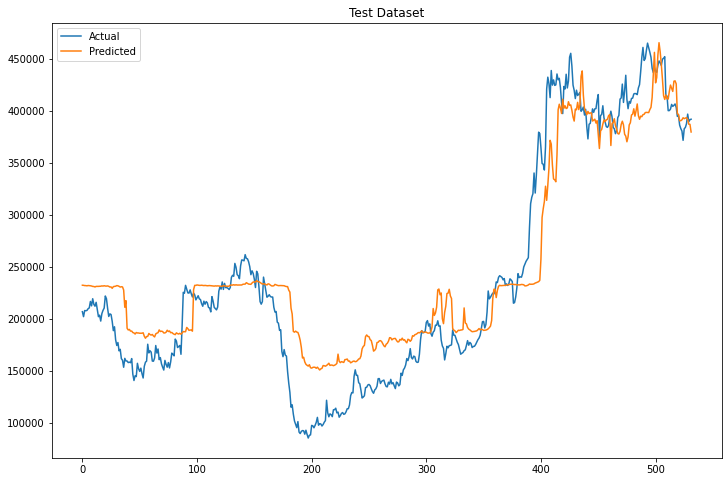

In [ ]:
plt.figure(figsize=(12,8))
y_test_pred = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(y_test_pred), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [ ]:
r2_score(y_test, y_test_pred)

0.8788657190042344

In [ ]:
r2_score(y_train, y_train_pred)

0.9443429885323822

In [ ]:
Xt= model.predict(X.reshape((len(X),10,1)))
yp=scl.inverse_transform(Xt)

In [ ]:
cl = my_data.Close.astype('float32')
train = cl[0:int(len(cl)*0.90)]
scl = MinMaxScaler()
#Scale the data
scl.fit(train.values.reshape(-1,1))
cl =scl.transform(cl.values.reshape(-1,1))
#Create a function to process the data into lb observations look back slices
# and create the train test dataset (90-10)

my_data['Close_scaled']=cl

def processData(data,lb):
    new_data = pd.DataFrame(index = my_data.index, data=np.array([data.Close_scaled.shift(-1*i).values for i in range(lb)]).T)
    Y=my_data['Close'].iloc[lb+1:].values
    X=new_data.values
    return np.array(X[:len(data)-lb-1]),np.array(Y[:len(data)-lb-1])

lb=10
#X1,y1 = processData(my_data,lb)
X1= np.c_[X[:,1:],yp.ravel()]
y1=Y=my_data['Close'].iloc[lb+1:].values
y1=np.array(y1[:-lb])

X_train,X_test = X1[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y1[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

4782 10
532 10
4782
532


In [ ]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

Predicting second day price, train data

Text(0.5, 1.0, 'Train Dataset')

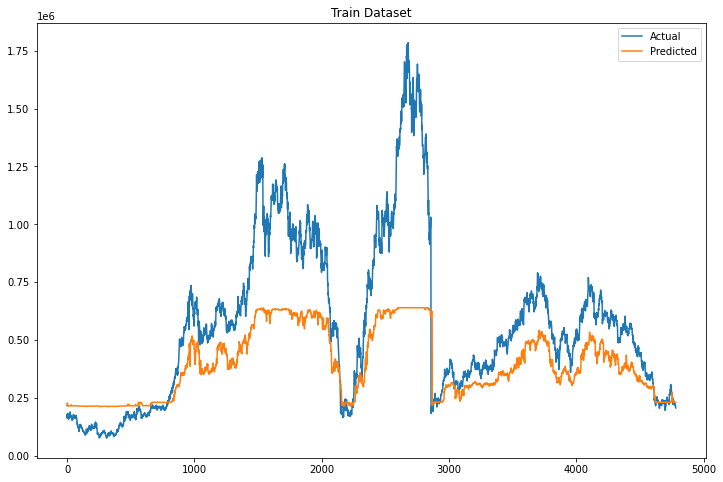

In [ ]:
plt.figure(figsize=(12,8))
y_train_pred = model.predict(X_train)
plt.plot(scl.inverse_transform(y_train.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(y_train_pred), label="Predicted")
plt.legend()
plt.title("Train Dataset")

Predicting second day price, train data

Text(0.5, 1.0, 'Test Dataset (2nd day prediction)')

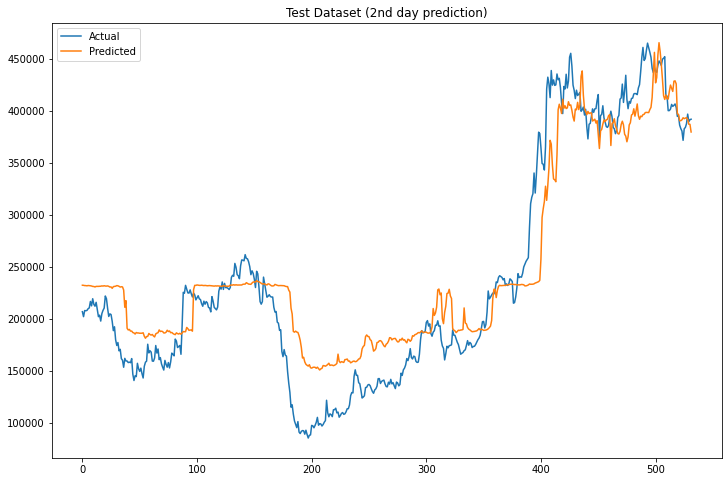

In [ ]:
plt.figure(figsize=(12,8))
y_test_pred = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(y_test_pred), label="Predicted")
plt.legend()
plt.title("Test Dataset (2nd day prediction)")

In [ ]:
from sklearn.metrics import r2_score


In [ ]:
r2_score(y_test, y_test_pred)

0.8788657190042344

In [ ]:
r2_score(y_train, y_train_pred)

0.3721533779066819